# Modelling and Evaluation Notebook

## Objectives 

* Answer business requirement 2:
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/cherry-leaves/test
* inputs/cherry-leaves/validation
* inputs/cherry-leaves/train
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

---

## Import regular packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

## Set up working directory

In [3]:
cwd= os.getcwd()

In [4]:
os.chdir('/workspaces/cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/workspaces/cherry-leaves'

---

## Setup input directory

Set train, validation and test paths.

In [8]:
my_data_dir = '/workspaces/cherry-leaves/inputs/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Setup output directory

In [6]:
version = 'v7'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set labels

In [9]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['powdery_mildew', 'healthy']


### Set image shape

In [15]:
## Import saved image shape embedding
import joblib
version = 'v2'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Explore the numbers of images in the validation, train and test datasets

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




NameError: name 'file_path' is not defined

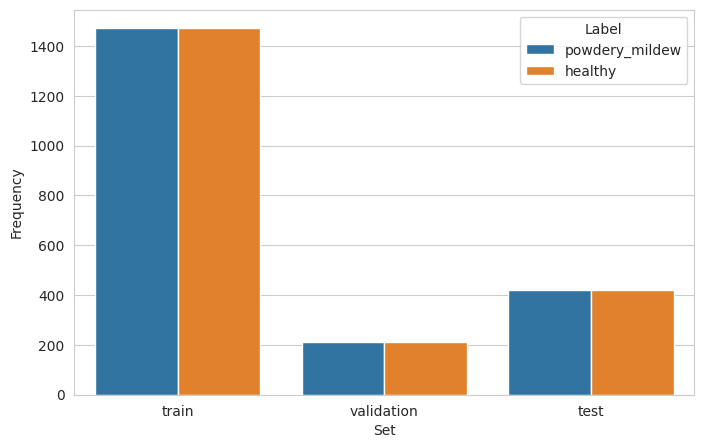

In [17]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

---

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Initialize ImageDataGenerator

In [20]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

#### Augment training image dataset

In [21]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment validation image dataset

In [22]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment test image dataset

In [23]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Plot augmented training image

(20, 256, 256, 3)


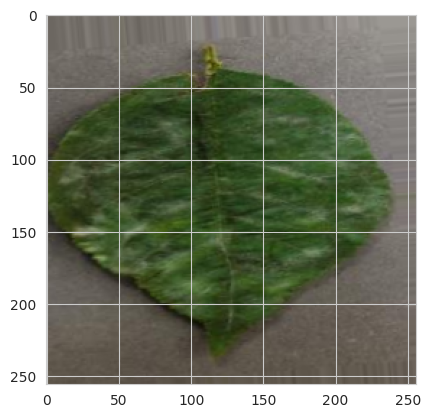

(20, 256, 256, 3)


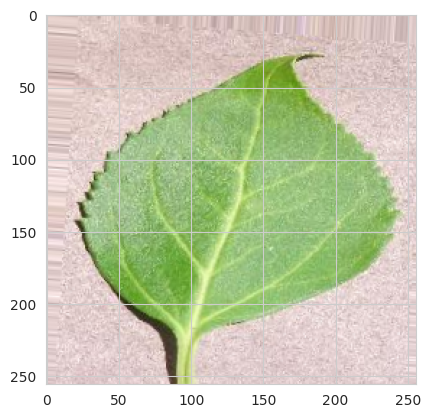

(20, 256, 256, 3)


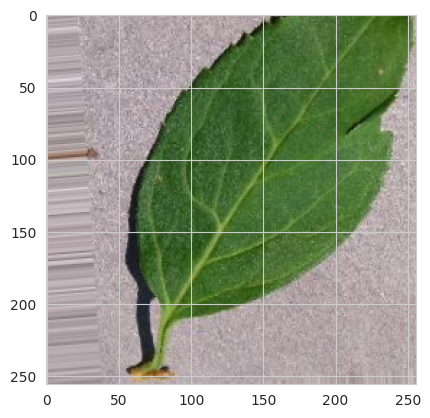

In [24]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented validation and test images

(20, 256, 256, 3)


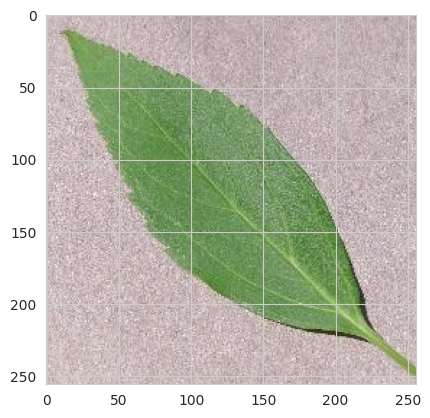

(20, 256, 256, 3)


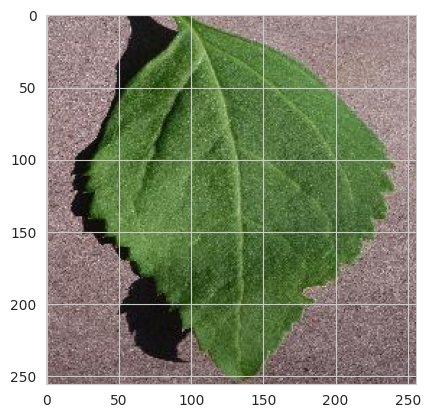

(20, 256, 256, 3)


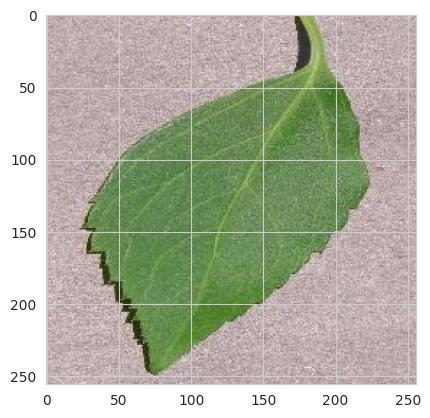

In [25]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


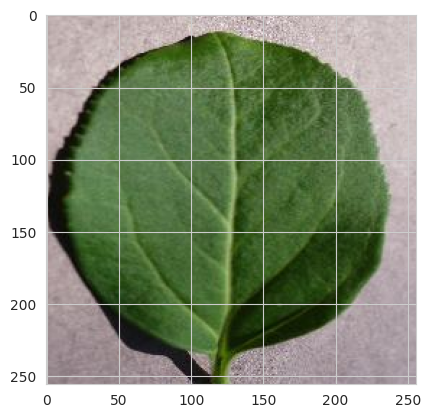

(20, 256, 256, 3)


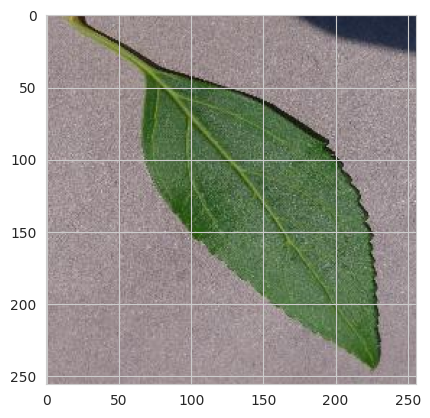

(20, 256, 256, 3)


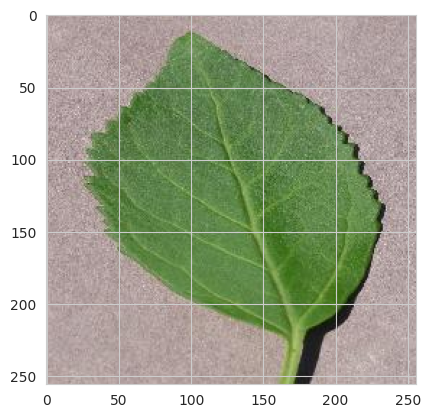

In [26]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

#### Save class_indices

In [17]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v7/class_indices.pkl']

---

### Create ML model

---

#### Import packages 

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

#### Model

In [29]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

#### Model Summary

In [30]:
create_tf_model().summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)            

#### Early stopping

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

#### Fit model for training

In [22]:
model = create_tf_model()
model.fit(train_set,
          epochs=30,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2023-12-29 14:35:05.793498: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
147/147 [==============================] - 876s 6s/step - loss: 0.3859 - accuracy: 0.8133 - val_loss: 0.0928 - val_accuracy: 0.9762
Epoch 2/30
147/147 [==============================] - 703s 5s/step - loss: 0.0981 - accuracy: 0.9709 - val_loss: 0.0415 - val_accuracy: 0.9905
Epoch 3/30
147/147 [==============================] - 735s 5s/step - loss: 0.0455 - accuracy: 0.9846 - val_loss: 0.0461 - val_accuracy: 0.9905
Epoch 4/30
147/147 [==============================] - 736s 5s/step - loss: 0.0601 - accuracy: 0.9812 - val_loss: 0.0242 - val_accuracy: 0.9929
Epoch 5/30
147/147 [==============================] - 664s 5s/step - loss: 0.0417 - accuracy: 0.9850 - val_loss: 0.0289 - val_accuracy: 0.9952
Epoch 6/30
147/147 [==============================] - 790s 5s/step - loss: 0.0423 - accuracy: 0.9873 - val_loss: 0.0434 - val_accuracy: 0.9929
Epoch 7/30
147/147 [==============================] - 666s 5s/step - loss: 0.0279 - accuracy: 0.9904 - val_loss: 0.0277 - val_accuracy: 0.9929

#### Save model

In [23]:
model.save('outputs/v1/cherry-leaves-model-h2')

2023-12-29 16:51:35.990924: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: outputs/v1/cherry-leaves-model-h2/assets


---

## Model Performance

---

#### Model learning curve

In [32]:
model = create_tf_model()
losses = pd.DataFrame(model.history.history)

sns.set_style("darkgrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

AttributeError: 'NoneType' object has no attribute 'history'

### Model evaluation

Load the saved model

In [34]:
from keras.models import load_model
model = load_model('outputs/v1/cherry-leaves-model-h2')

Evaluate the model on test set

In [35]:
evaluation = model.evaluate(test_set)

2023-12-30 09:01:23.624453: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


43/43 [==============================] - 80s 738ms/step - loss: 0.0407 - accuracy: 0.9917


### Save evaluation pickle

In [36]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Predict on new data

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


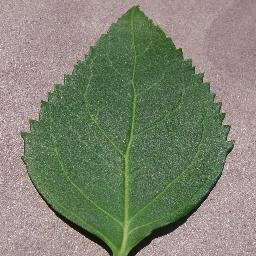

In [40]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[1]  # select healthy or powdery_mildew

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [41]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [42]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9999838401054149
healthy


## Push files to Repo

* .gitignore

In [43]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

* Git status

In [44]:
!git status

Refresh index: 100% (4242/4242), done.
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   jupyter_notebooks/.ipynb_checkpoints/Modelling and Evaluating-checkpoint.ipynb
	modified:   jupyter_notebooks/Modelling and Evaluating.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	outputs/v1/cherry-leaves-model-h2/
	outputs/v1/evaluation.pkl
	outputs/v7/

no changes added to commit (use "git add" and/or "git commit -a")


* Git add

In [ ]:
!git add .

* Git commit

In [ ]:
!git commit -am " Add create model and model evaluation"

* Git Push

In [ ]:
!git push